<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/08-interp/Shap_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip search shap | grep INSTALLED || pip install shap

  INSTALLED: 0.29.1 (latest)


In [2]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import tensorflow as tf
import requests
from skimage.segmentation import slic
import matplotlib.pylab as pl
import numpy as np
import shap

Using TensorFlow backend.


In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.13.1


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
feature_names = r.json()

In [0]:
model = VGG16()

In [0]:
!wget -q 'https://boygeniusreport.files.wordpress.com/2016/11/puppy-dog.jpg?quality=98&strip=all&w=782' -O ./puppy.jpg

In [0]:
file = "./puppy.jpg"
img = image.load_img(file, target_size=(224, 224))
img_orig = image.img_to_array(img)

In [0]:
N_Segm = 24

In [0]:
segments_slic = slic(img, n_segments=N_Segm, compactness=30, sigma=3)

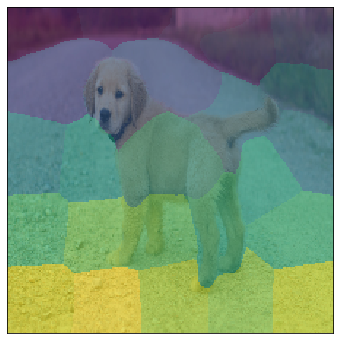

In [11]:
pl.figure(figsize=(6,6))
fig = pl.imshow(segments_slic);
pl.imshow(img,alpha=0.4)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [0]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [13]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,N_Segm)))
shap_values = explainer.shap_values(np.ones((1,N_Segm)), nsamples=60) 

100%|██████████| 1/1 [00:17<00:00, 17.66s/it]


In [0]:
# get the top predictions from the model
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)

In [0]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

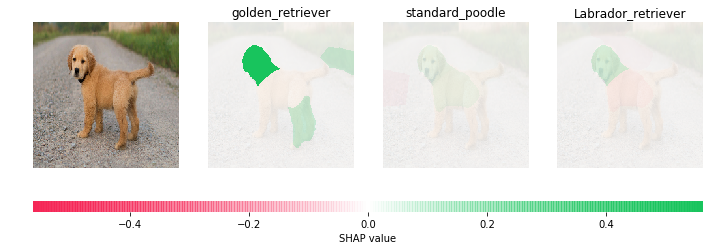

In [16]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img, alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
pl.show()